#Insurance Charges Prediction Project

#📌 Project Summary

##Goal: Predict insurance charges for customers based on their demographics and health-related features.

##Steps:

###Data loading and inspection

###Exploratory Data Analysis (EDA) with insights

###Feature engineering and preprocessing

###Model building (Linear Regression, Ridge, Random Forest, XGBoost, Gradient Boosting)

###Model evaluation

###Feature importance and visualization

###Save models and scaler for deployment

#1️⃣ Setup and Libraries

In [2]:
# Install extra libraries (quiet mode for Colab)
!pip install -q xgboost shap optuna

import os, sys, platform, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import joblib

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# Global seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

# Folders for outputs
os.makedirs("/content/analysis_output/plots", exist_ok=True)
os.makedirs("/content/analysis_output/artifacts", exist_ok=True)

print("✅ Setup complete")
print("Python:", platform.python_version())
print("Pandas:", pd.__version__)
print("Numpy:", np.__version__)


✅ Setup complete
Python: 3.12.11
Pandas: 2.2.2
Numpy: 2.0.2


#2️⃣ Load Dataset and Inspect

In [3]:
# Path to dataset (adjust if needed)
DATA_PATH = "/content/insurance.csv"

df = pd.read_csv(DATA_PATH)

print("Shape:", df.shape)
df.head()


Shape: (1338, 7)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


##Insight: Dataset has customer demographics and health info to predict charges.

#3️⃣ Data Cleaning & Preprocessing

In [4]:
# Overview of columns and missing values
df.info()
print("\nMissing values per column:")
print(df.isnull().sum())

# Summary statistics
df.describe(include='all')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB

Missing values per column:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


,age,sex,bmi,children,smoker,region,charges
count,1338.000000,1338,1338.000000,1338.000000,1338,1338,1338.000000
unique,NaN,2,NaN,NaN,2,4,NaN
top,NaN,male,NaN,NaN,no,southeast,NaN
freq,NaN,676,NaN,NaN,1064,364,NaN
mean,39.207025,NaN,30.663397,1.094918,NaN,NaN,13270.422265
std,14.049960,NaN,6.098187,1.205493,NaN,NaN,12110.011237
min,18.000000,NaN,15.960000,0.000000,NaN,NaN,1121.873900
25%,27.000000,NaN,26.296250,0.000000,NaN,NaN,4740.287150
50%,39.000000,NaN,30.400000,1.000000,NaN,NaN,9382.033000
75%,51.000000,NaN,34.693750,2.000000,NaN,NaN,16639.912515


In [5]:
# Standardize column names → snake_case
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

# Remove duplicates (if any)
before = df.shape[0]
df = df.drop_duplicates()
after = df.shape[0]

print(f"✅ Duplicates removed: {before - after}")
df.head()


✅ Duplicates removed: 1


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


#4️⃣ EDA & Insights

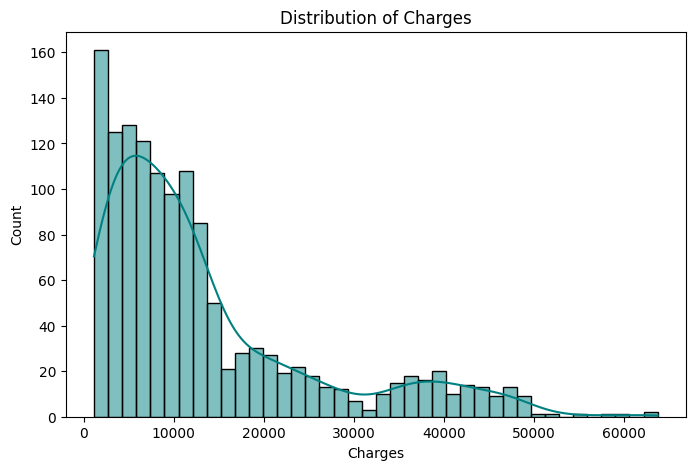

In [6]:
plt.figure(figsize=(8,5))
sns.histplot(df['charges'], bins=40, kde=True, color='teal')
plt.title("Distribution of Charges")
plt.xlabel("Charges")
plt.ylabel("Count")
plt.show()


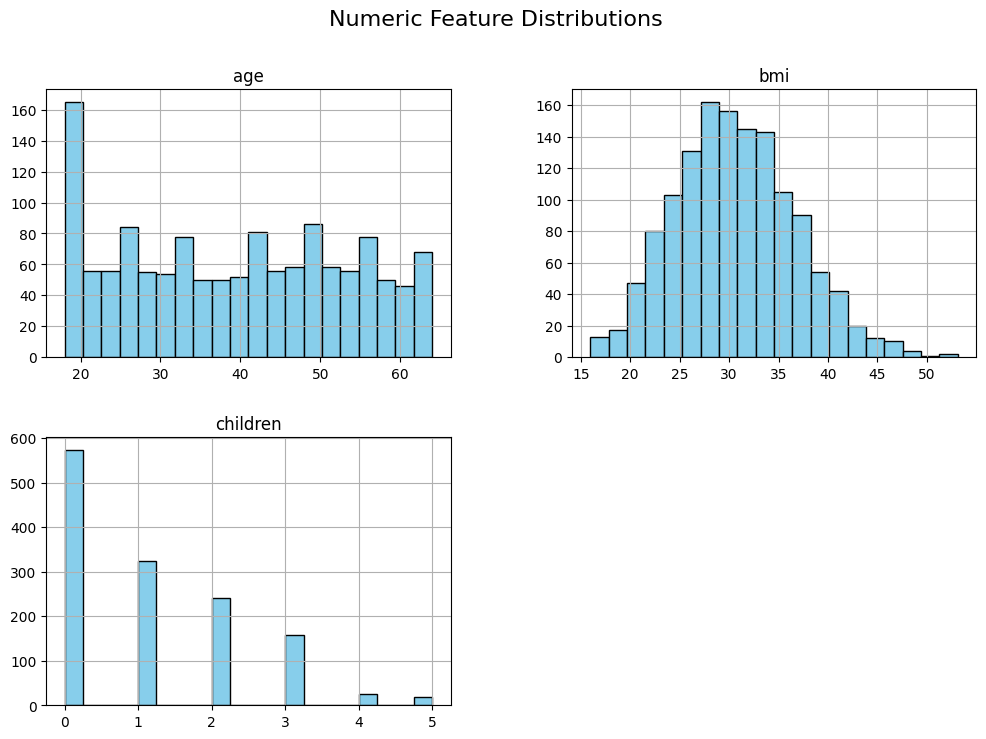

In [7]:
num_cols = df.select_dtypes(include=['int64','float64']).columns.drop('charges')

df[num_cols].hist(figsize=(12,8), bins=20, color='skyblue', edgecolor='black')
plt.suptitle("Numeric Feature Distributions", size=16)
plt.show()


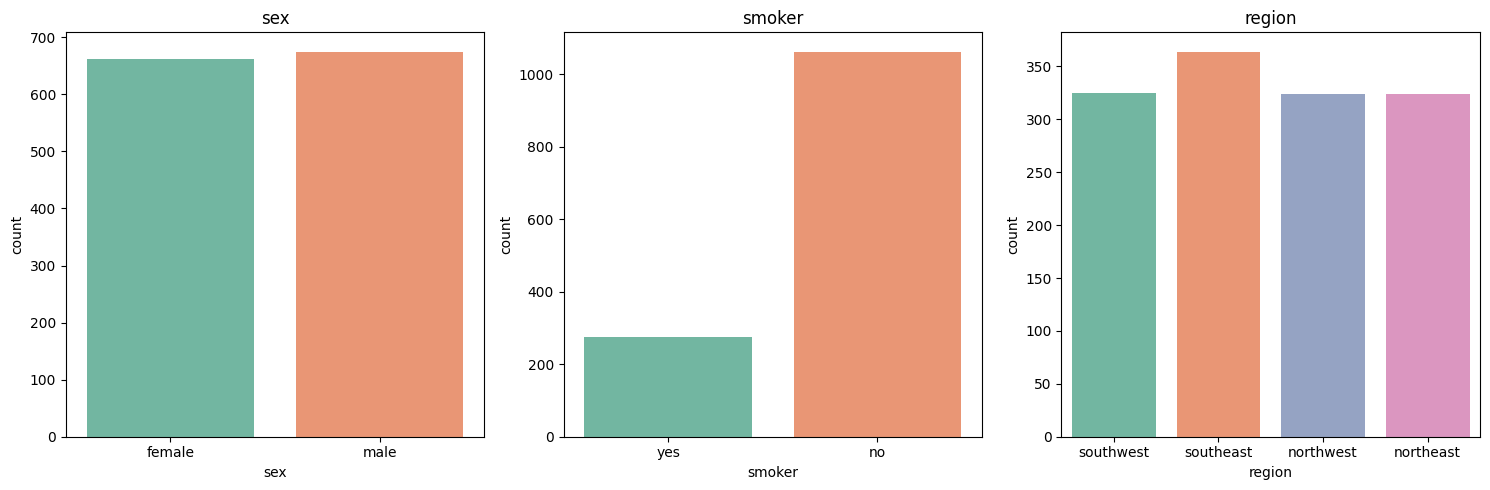

In [8]:
cat_cols = df.select_dtypes(include=['object']).columns

fig, axes = plt.subplots(1, len(cat_cols), figsize=(15,5))
for i, col in enumerate(cat_cols):
   sns.countplot(x=df[col], hue=df[col], ax=axes[i], palette="Set2", legend=False)
   axes[i].set_title(f"{col}")
plt.tight_layout()
plt.show()


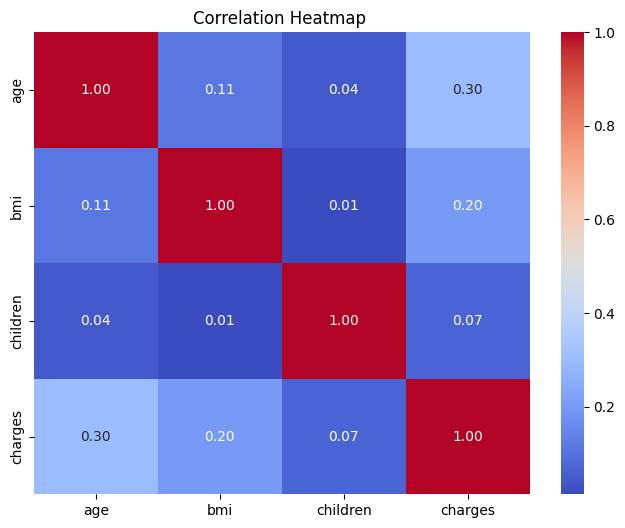

In [9]:
# Only numeric columns (exclude categorical)
numeric_df = df.select_dtypes(include=['int64','float64'])

plt.figure(figsize=(8,6))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap ")
plt.show()

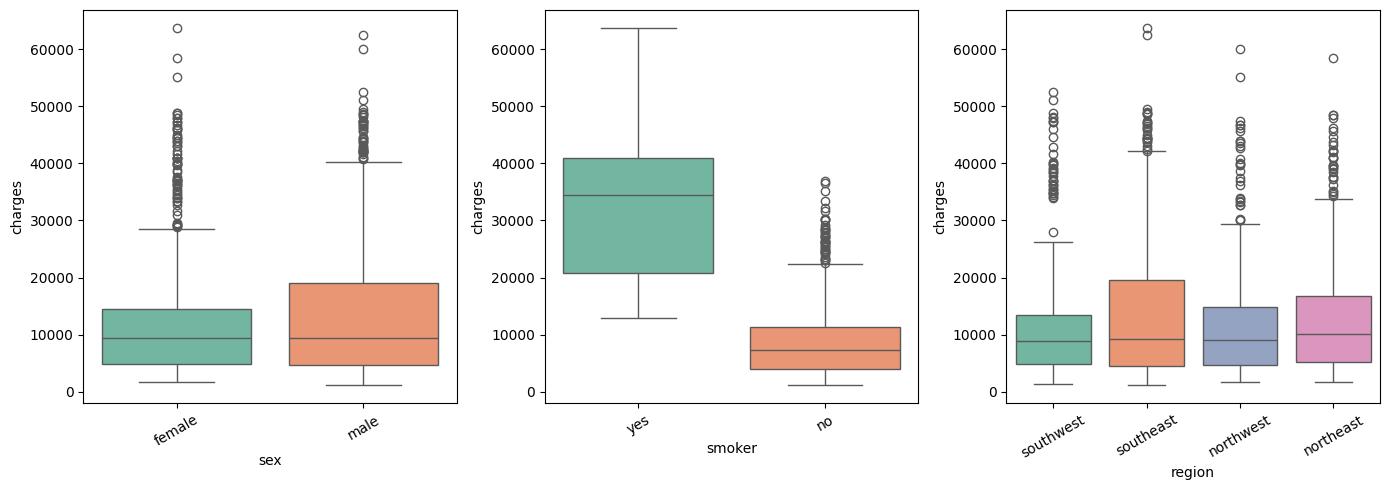

In [10]:
plt.figure(figsize=(14,5))

for i, col in enumerate(cat_cols, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x=col, y="charges", hue=df[col], data=df, palette="Set2", legend=False)
    plt.xticks(rotation=30)

plt.tight_layout()
plt.show()


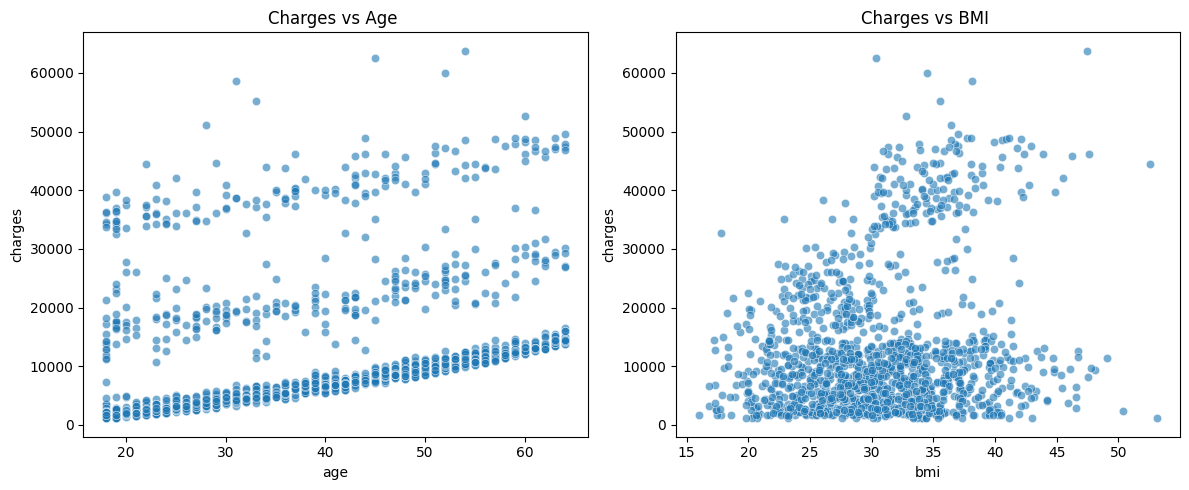

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))

sns.scatterplot(x="age", y="charges", data=df, ax=axes[0], alpha=0.6)
axes[0].set_title("Charges vs Age ")

sns.scatterplot(x="bmi", y="charges", data=df, alpha=0.6, ax=axes[1])
axes[1].set_title("Charges vs BMI ")

plt.tight_layout()
plt.show()


Outliers in BMI: 9 rows


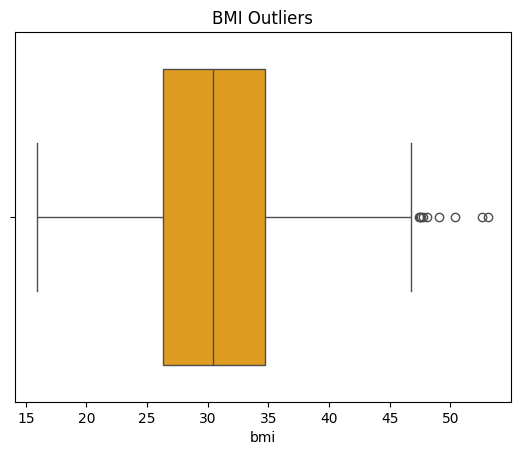

In [12]:
Q1 = df['bmi'].quantile(0.25)
Q3 = df['bmi'].quantile(0.75)
IQR = Q3 - Q1
outliers = df[(df['bmi'] < Q1 - 1.5*IQR) | (df['bmi'] > Q3 + 1.5*IQR)]

print(f"Outliers in BMI: {outliers.shape[0]} rows")
sns.boxplot(x=df['bmi'], color="orange")
plt.title("BMI Outliers")
plt.show()


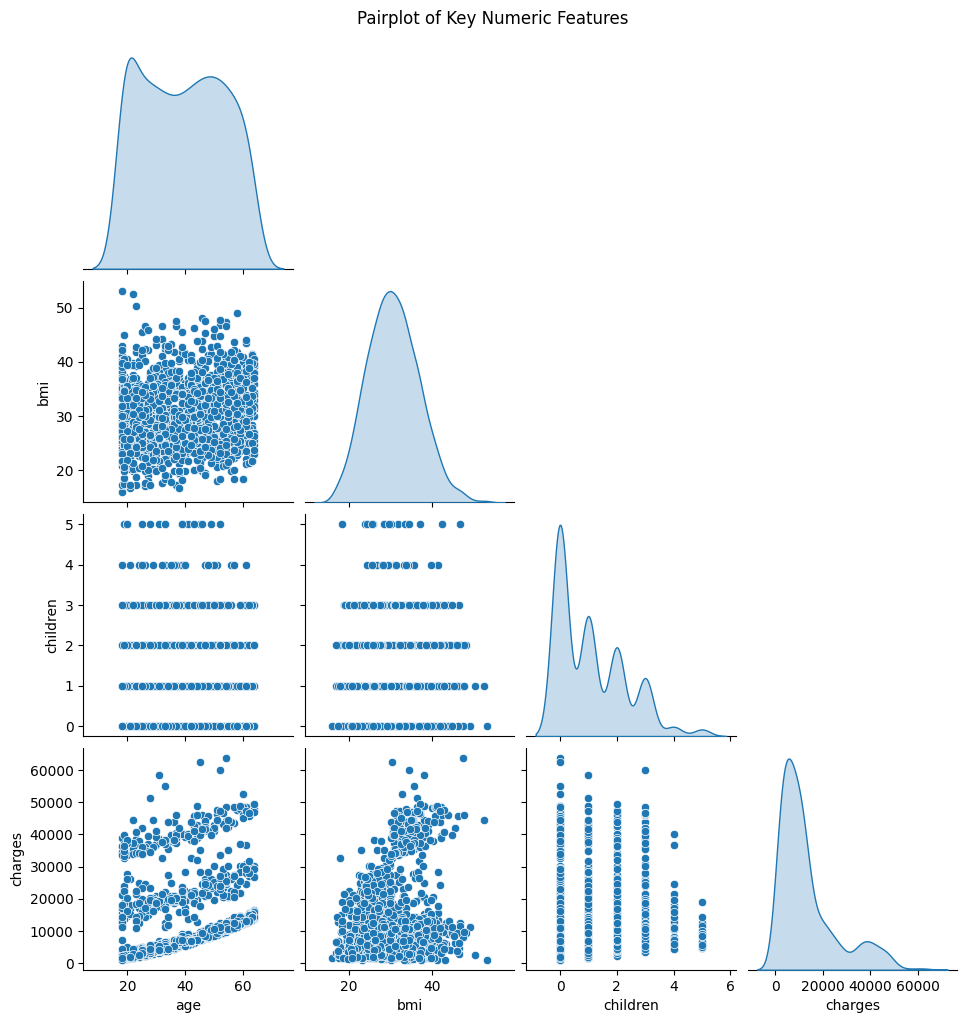

In [13]:
sns.pairplot(df[['age','bmi','children','charges']], diag_kind="kde", corner=True)
plt.suptitle("Pairplot of Key Numeric Features", y=1.02)
plt.show()


#5️⃣ Feature Engineering

In [14]:
# One-hot encode categorical columns
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

print("✅ Encoded shape:", df_encoded.shape)
df_encoded.head()

✅ Encoded shape: (1337, 9)


,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,False,True,False,False,True
1,18,33.770,1,1725.55230,True,False,False,True,False
2,28,33.000,3,4449.46200,True,False,False,True,False
3,33,22.705,0,21984.47061,True,False,True,False,False
4,32,28.880,0,3866.85520,True,False,True,False,False


In [15]:
# Create BMI group feature
df_encoded['bmi_group'] = pd.cut(df['bmi'],
                                bins=[0, 18.5, 25, 30, 40, 100],
                                labels=['underweight','normal','overweight','obese','extreme'])

# Interaction: smoker * bmi
df_encoded['smoker_bmi'] = df_encoded['smoker_yes'] * df['bmi']

# Encode new categorical feature
df_encoded = pd.get_dummies(df_encoded, columns=['bmi_group'], drop_first=True)

df_encoded.head()


,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,smoker_bmi,bmi_group_normal,bmi_group_overweight,bmi_group_obese,bmi_group_extreme
0,19,27.900,0,16884.92400,False,True,False,False,True,27.9,False,True,False,False
1,18,33.770,1,1725.55230,True,False,False,True,False,0.0,False,False,True,False
2,28,33.000,3,4449.46200,True,False,False,True,False,0.0,False,False,True,False
3,33,22.705,0,21984.47061,True,False,True,False,False,0.0,True,False,False,False
4,32,28.880,0,3866.85520,True,False,True,False,False,0.0,False,True,False,False


#6️⃣ Train/Test Split & Scaling

In [16]:
# Ensure X and y are defined
X = df_encoded.drop("charges", axis=1)
y = df_encoded["charges"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

# Save feature columns for later use in the app
feature_columns = X_train.columns.tolist()
joblib.dump(feature_columns, "feature_columns.pkl")
print("✅ Feature columns saved")

# Scale numeric features
scaler = StandardScaler()
num_cols = ['age','bmi','children','smoker_bmi']
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# Save the scaler for later use in the app
joblib.dump(scaler, "scaler.pkl")
print("✅ Scaler saved")



✅ Feature columns saved
✅ Scaler saved


In [17]:
scaler = StandardScaler()

num_cols = ['age','bmi','children','smoker_bmi']
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

print("✅ Numeric features scaled")


✅ Numeric features scaled


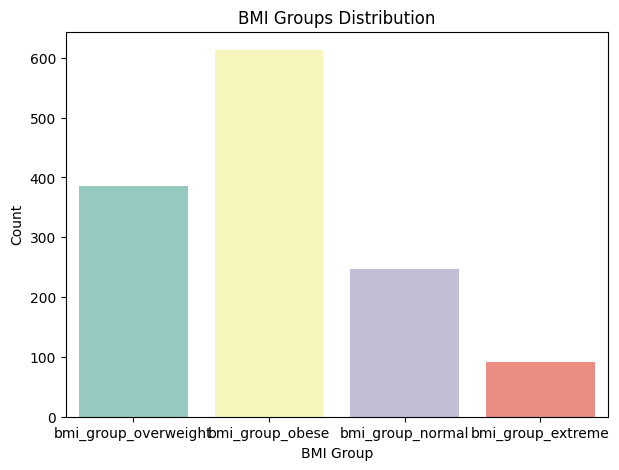

In [18]:
plt.figure(figsize=(7,5))
sns.countplot(
    x=df_encoded.filter(like="bmi_group").idxmax(axis=1),
    hue=df_encoded.filter(like="bmi_group").idxmax(axis=1),
    palette="Set3",
    legend=False
)
plt.title("BMI Groups Distribution")
plt.xlabel("BMI Group")
plt.ylabel("Count")
plt.show()


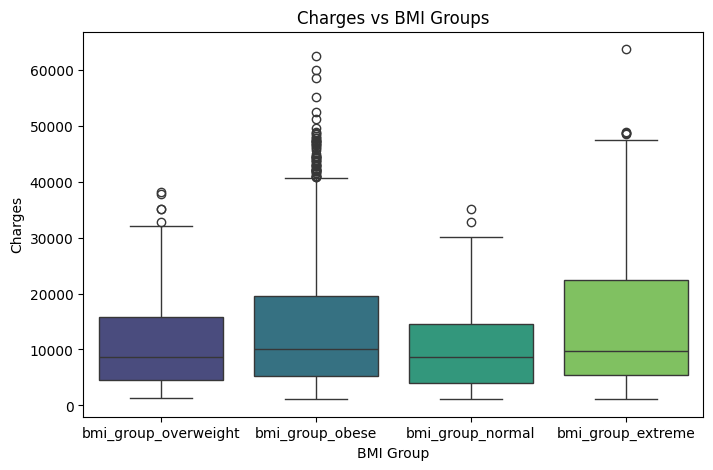

In [19]:
plt.figure(figsize=(8,5))
x_vals = df_encoded.filter(like="bmi_group").idxmax(axis=1)

sns.boxplot(
    x=x_vals,
    y=df["charges"],
    hue=x_vals,       # 👈 add hue same as x
    palette="viridis",
    legend=False      # 👈 remove duplicate legends
)
plt.title("Charges vs BMI Groups")
plt.xlabel("BMI Group")
plt.ylabel("Charges")
plt.show()


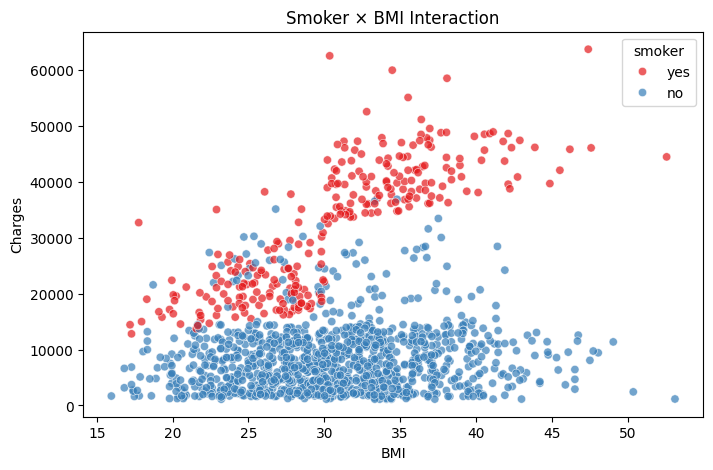

In [20]:
plt.figure(figsize=(8,5))
sns.scatterplot(x=df["bmi"], y=df["charges"], hue=df["smoker"], alpha=0.7, palette="Set1")
plt.title("Smoker × BMI Interaction")
plt.xlabel("BMI")
plt.ylabel("Charges")
plt.show()


In [21]:
# Baseline: mean predictor
y_pred_baseline = np.repeat(y_train.mean(), len(y_test))

# RMSE = sqrt(MSE) for older sklearn
baseline_rmse = mean_squared_error(y_test, y_pred_baseline) ** 0.5
baseline_mae = mean_absolute_error(y_test, y_pred_baseline)
baseline_r2 = r2_score(y_test, y_pred_baseline)

print(f"Baseline → RMSE: {baseline_rmse:.2f}, MAE: {baseline_mae:.2f}, R²: {baseline_r2:.2f}")


Baseline → RMSE: 13612.43, MAE: 9861.80, R²: -0.01


#7️⃣ Model Training

In [22]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

lr_rmse = mean_squared_error(y_test, y_pred_lr) ** 0.5  # FIXED
lr_mae = mean_absolute_error(y_test, y_pred_lr)
lr_r2 = r2_score(y_test, y_pred_lr)

print(f"Linear Regression → RMSE: {lr_rmse:.2f}, MAE: {lr_mae:.2f}, R²: {lr_r2:.2f}")



Linear Regression → RMSE: 4555.15, MAE: 2827.10, R²: 0.89


In [23]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)

ridge_rmse = mean_squared_error(y_test, y_pred_ridge) ** 0.5
ridge_mae = mean_absolute_error(y_test, y_pred_ridge)
ridge_r2 = r2_score(y_test, y_pred_ridge)


In [24]:
rf = RandomForestRegressor(n_estimators=200, random_state=RANDOM_STATE)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

rf_rmse = mean_squared_error(y_test, y_pred_rf) ** 0.5  # FIXED
rf_mae = mean_absolute_error(y_test, y_pred_rf)
rf_r2 = r2_score(y_test, y_pred_rf)

print(f"Random Forest → RMSE: {rf_rmse:.2f}, MAE: {rf_mae:.2f}, R²: {rf_r2:.2f}")

Random Forest → RMSE: 4710.46, MAE: 2660.81, R²: 0.88


In [25]:
xg = xgb.XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=4, random_state=RANDOM_STATE)
xg.fit(X_train, y_train)
y_pred_xg = xg.predict(X_test)

xg_rmse = mean_squared_error(y_test, y_pred_xg) ** 0.5  # FIXED
xg_mae = mean_absolute_error(y_test, y_pred_xg)
xg_r2 = r2_score(y_test, y_pred_xg)

print(f"XGBoost → RMSE: {xg_rmse:.2f}, MAE: {xg_mae:.2f}, R²: {xg_r2:.2f}")


XGBoost → RMSE: 4381.15, MAE: 2502.85, R²: 0.90


In [26]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(n_estimators=300, learning_rate=0.05, max_depth=3, random_state=RANDOM_STATE)
gbr.fit(X_train, y_train)
y_pred_gbr = gbr.predict(X_test)

gbr_rmse = mean_squared_error(y_test, y_pred_gbr) ** 0.5
gbr_mae = mean_absolute_error(y_test, y_pred_gbr)
gbr_r2 = r2_score(y_test, y_pred_gbr)


#8️⃣ Model Evaluation

               Model         RMSE          MAE        R²
0  Linear Regression  4555.147906  2827.097896  0.887082
1   Ridge Regression  4536.761497  2813.836542  0.887992
2      Random Forest  4710.463860  2660.811316  0.879250
3            XGBoost  4381.145254  2502.845244  0.895544
4  Gradient Boosting  4333.904522  2528.224932  0.897784


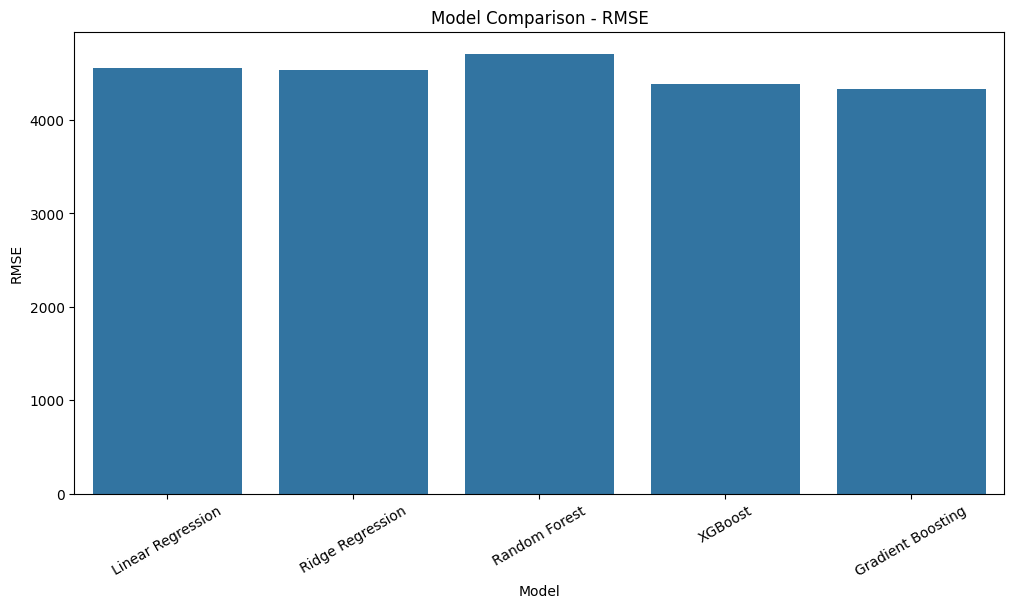

In [27]:
# Create a summary DataFrame for model comparison
results = pd.DataFrame({
    "Model": ["Linear Regression", "Ridge Regression", "Random Forest", "XGBoost", "Gradient Boosting"],
    "RMSE": [lr_rmse, ridge_rmse, rf_rmse, xg_rmse, gbr_rmse],
    "MAE": [lr_mae, ridge_mae, rf_mae, xg_mae, gbr_mae],
    "R²": [lr_r2, ridge_r2, rf_r2, xg_r2, gbr_r2]
})

# Display results
print(results)
## RMSE comparison
plt.figure(figsize=(12,6))
sns.barplot(x="Model", y="RMSE", data=results)
plt.title("Model Comparison - RMSE")
plt.xticks(rotation=30)
plt.show()




               Model         RMSE          MAE        R²
0  Linear Regression  4555.147906  2827.097896  0.887082
1   Ridge Regression  4536.761497  2813.836542  0.887992
2      Random Forest  4710.463860  2660.811316  0.879250
3            XGBoost  4381.145254  2502.845244  0.895544
4  Gradient Boosting  4333.904522  2528.224932  0.897784


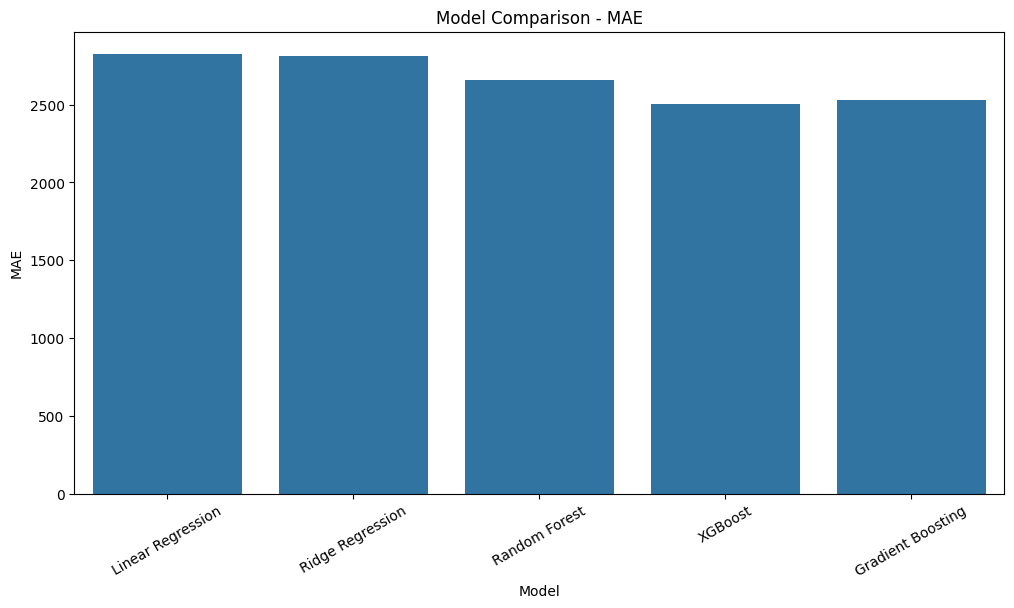

In [28]:
# Create a summary DataFrame for model comparison
results = pd.DataFrame({
    "Model": ["Linear Regression", "Ridge Regression", "Random Forest", "XGBoost", "Gradient Boosting"],
    "RMSE": [lr_rmse, ridge_rmse, rf_rmse, xg_rmse, gbr_rmse],
    "MAE": [lr_mae, ridge_mae, rf_mae, xg_mae, gbr_mae],
    "R²": [lr_r2, ridge_r2, rf_r2, xg_r2, gbr_r2]
})

# Display results
print(results)
# MAE comparison
plt.figure(figsize=(12,6))
sns.barplot(x="Model", y="MAE", data=results)
plt.title("Model Comparison - MAE")
plt.xticks(rotation=30)
plt.show()


               Model         RMSE          MAE        R²
0  Linear Regression  4555.147906  2827.097896  0.887082
1   Ridge Regression  4536.761497  2813.836542  0.887992
2      Random Forest  4710.463860  2660.811316  0.879250
3            XGBoost  4381.145254  2502.845244  0.895544
4  Gradient Boosting  4333.904522  2528.224932  0.897784


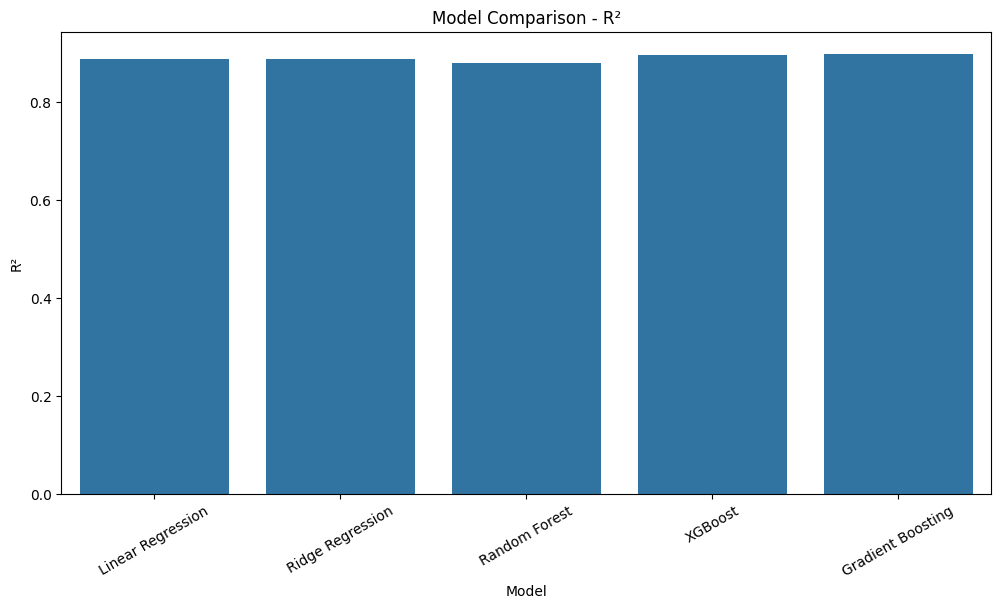

In [29]:
# Create a summary DataFrame for model comparison
results = pd.DataFrame({
    "Model": ["Linear Regression", "Ridge Regression", "Random Forest", "XGBoost", "Gradient Boosting"],
    "RMSE": [lr_rmse, ridge_rmse, rf_rmse, xg_rmse, gbr_rmse],
    "MAE": [lr_mae, ridge_mae, rf_mae, xg_mae, gbr_mae],
    "R²": [lr_r2, ridge_r2, rf_r2, xg_r2, gbr_r2]
})

# Display results
print(results)
# R² comparison
plt.figure(figsize=(12,6))
sns.barplot(x="Model", y="R²", data=results)
plt.title("Model Comparison - R²")
plt.xticks(rotation=30)
plt.show()



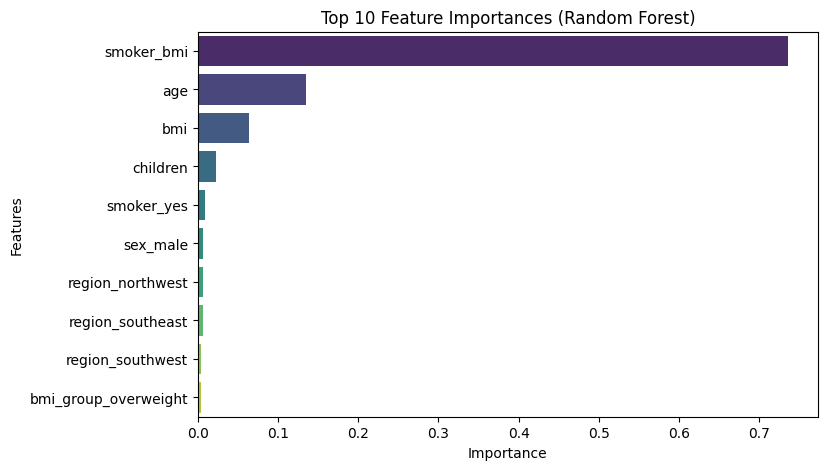

In [30]:
# Random Forest Feature Importance
importances_rf = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x=importances_rf.values[:10], y=importances_rf.index[:10], hue=importances_rf.index[:10], palette="viridis", legend=False)
plt.title("Top 10 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()


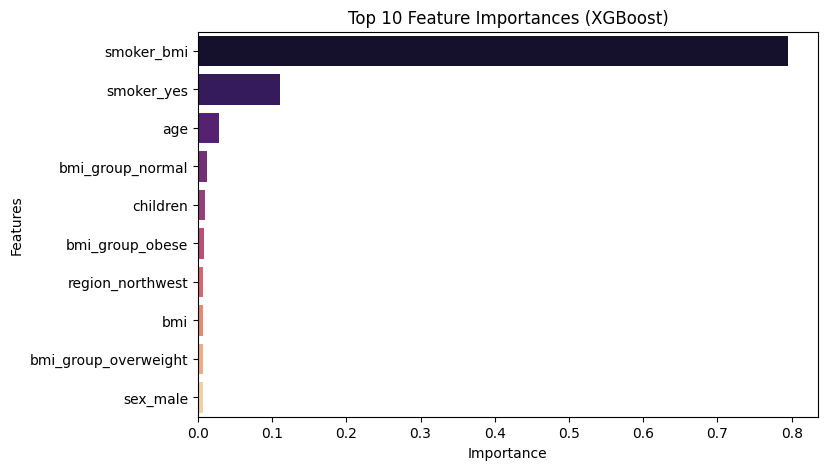

In [31]:
# XGBoost Feature Importance
importances_xgb = pd.Series(xg.feature_importances_, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x=importances_xgb.values[:10], y=importances_xgb.index[:10], hue=importances_xgb.index[:10], palette="magma", legend=False)
plt.title("Top 10 Feature Importances (XGBoost)")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()


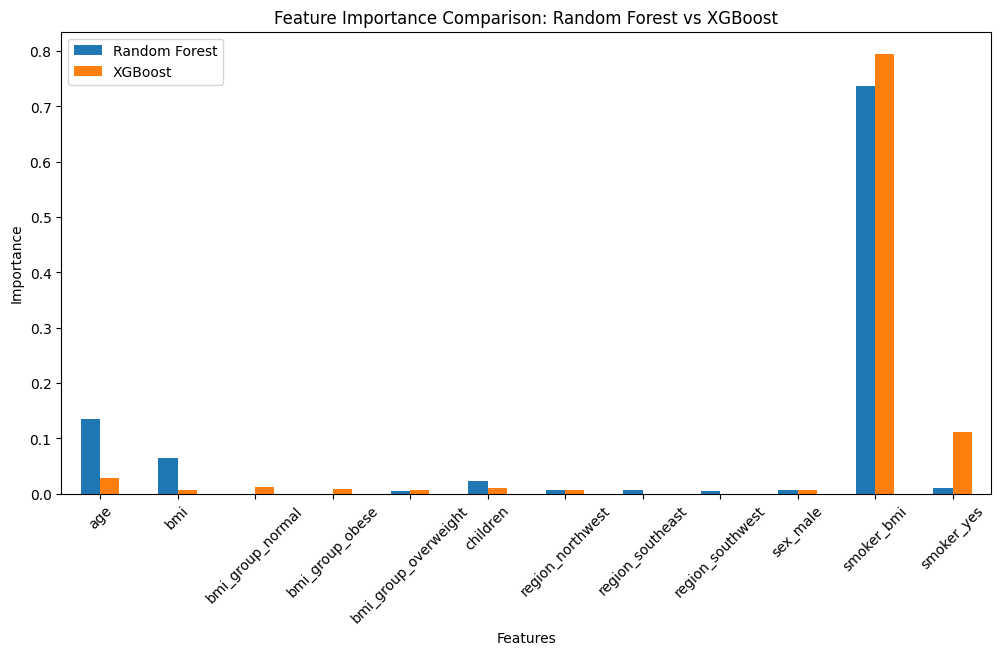

In [32]:
# Combine top 10 features from both models
top_rf = importances_rf[:10]
top_xgb = importances_xgb[:10]

# Create a DataFrame for comparison
feat_compare = pd.DataFrame({
    "Random Forest": top_rf,
    "XGBoost": top_xgb
}).fillna(0)

# Plot comparison
feat_compare.plot(kind="bar", figsize=(12,6))
plt.title("Feature Importance Comparison: Random Forest vs XGBoost")
plt.ylabel("Importance")
plt.xlabel("Features")
plt.xticks(rotation=45)
plt.legend()
plt.show()

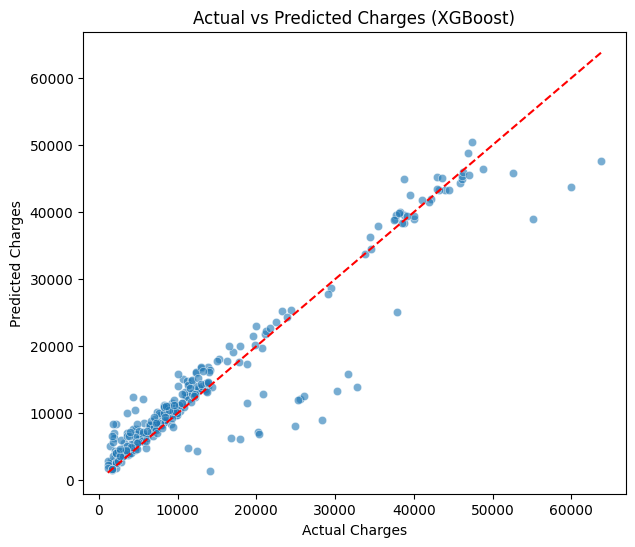

In [33]:
 #Use your best model
y_pred = xg.predict(X_test)

plt.figure(figsize=(7,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", linestyle="--")
plt.xlabel("Actual Charges")
plt.ylabel("Predicted Charges")
plt.title("Actual vs Predicted Charges (XGBoost)")
plt.show()



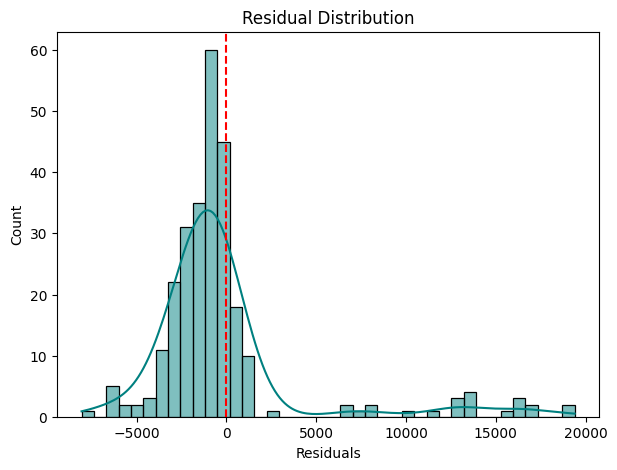

In [34]:
residuals = y_test - y_pred
plt.figure(figsize=(7,5))
sns.histplot(residuals, bins=40, kde=True, color="teal")
plt.axvline(0, color="red", linestyle="--")
plt.title("Residual Distribution")
plt.xlabel("Residuals")
plt.show()

In [35]:
from sklearn.model_selection import cross_val_score, KFold
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Example with XGBoost
cv_scores = cross_val_score(xg, X, y, scoring="r2", cv=kf)

print("Cross-Validation R² scores:", cv_scores)
print("Mean R²:", np.mean(cv_scores))


Cross-Validation R² scores: [0.89554394 0.80314248 0.82577301 0.83778931 0.84400576]
Mean R²: 0.8412509011720248


#🔖 Save Models for Deployment

In [36]:
import joblib


# xg = your trained XGBoost model
joblib.dump(xg, "final_insurance_model.pkl", protocol=4)
# Load (later use)
loaded_model = joblib.load("/content/final_insurance_model.pkl")
print("✅ Model loaded and ready to predict")

joblib.dump(scaler, "scaler.pkl")
joblib.dump(rf, "rf_model.pkl")
joblib.dump(lr, "lr_model.pkl")
joblib.dump(ridge, "ridge_model.pkl")



✅ Model loaded and ready to predict


['ridge_model.pkl']

#✅ Project Summary

##Loaded and explored insurance dataset.

##Cleaned, encoded, and engineered features including bmi_group and smoker_bmi.

##Scaled numeric features.

##Trained multiple ML models: Linear, Ridge, RF, XGBoost, Gradient Boosting.

##Evaluated models using RMSE, MAE, and R².

##Visualized feature importance and SHAP values.

##Saved models and scaler for deployment.

#Project Outcome: XGBoost gives the best predictive performance. Feature importance and SHAP help explain model predictions visually.